In [7]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data
from codelib.statistics import calculate_cornish_fisher_percentile

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 3

In this week we will look at a few exercises involving univariate and multivariate statistics and risk measures. 



## Problem 1: VaR and CVaR using historical simulation 

A common approach to estimate $\text{VaR}$ and $\text{CVaR}$ is simply to use or simulate from the empirical distribution function. Some are strong proponents of this method since it does not require distributional assumptions about returns, but one need to be carefull since one will often make an independence assumption and sometimes a particular model assumption may give more robust results. Blindly using the empirical distribution may limit the attention to tail events. 



__Question 1__

Obtain the equally weighted monthly return data for the five Fama-French industry portfolios ("5_Industry_Portfolios") using `pandas-datareader` since 1990-01-01  and transform the equally weighted monthly return data into log returns.


__Question 2__

Resample 10,000 vectors of returns from the monthly log returns calculated above. Use e.g. `np.random.randint`. Plot the histogram an equally weighted portfolio (linear returns). Calculate the 5\% $\text{VaR}$ and $\text{CVaR}$ of an equally weighted portfolio (linear returns) using the resampled / simulated data. 

__Question 3__

Resample 10,000 x 12 vectors of returns from the monthly log returns calculate above such to you are able to calculate the yearly portfolio return. Use e.g. `np.random.randint`. Plot the histogram of an equally weighted portfolio (yearly, linear returns). Calculate the 5\% $\text{VaR}$ and $\text{CVaR}$ of an equally weighted portfolio (linear returns) using the resampled / simulated data.

__Question 4__

Based on the portfolio returns found in question 3, use the Cornish-Fisher approximation to calculate the 5\% $\text{VaR}$ of the yearly portfolio return. Note the function `calculate_cornish_fisher_percentile` in `codelib.statistics`.

### Solution 

__Question 1__

In [8]:
# import pandas_datareader as pdr
# from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

reader = FamaFrenchReader("5_Industry_Portfolios", start=datetime.datetime(1990, 1, 1))
industry_port_daily = reader.read()

# print description
industry_port_daily['DESCR']

# get equally weighted
ind_eq_weighted = industry_port_daily[1]

# get log returns
eq_log_returns = np.log1p(ind_eq_weighted / 100.0)
eq_log_returns.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
1990-01,-0.057947,-0.044056,-0.058053,-0.056253,-0.053506
1990-02,0.018036,0.029170,0.031983,0.015578,0.009158
1990-03,0.034981,0.037488,0.038259,0.043730,-0.001802
1990-04,-0.024600,-0.026857,-0.021019,-0.008637,-0.035420
1990-05,0.042485,0.046884,0.074458,0.078441,0.022055


In [9]:
eq_log_returns.shape

(379, 5)

__Question 2__

In [10]:
"""
Define resampling function 
"""

def resample(data: np.ndarray, num_sim: int, num_per: int = 1):
    
    """
    Resample input data

    Parameters
    ----------
    data: 
        Data matrix, time x assets
    num_sim: 
        Number of simulations. 
    num_per: 
        Number of periods. 

    Returns
    -------
    np.ndarray
        Ressampled data, (num_sim, num_per, number of assets)

    """
    # number of assets
    n = len(data)
    # get index for selecting data
    idx = np.random.randint(n, size=(num_sim, num_per))
    
    return data[idx, :]

In [11]:
"""
Simulate one month log-returns and transform to port. returns
"""
port_w = np.repeat(1.0/5.0, 5)
num_sim = 10000
num_per = 1

sim_log_returns = resample(eq_log_returns.values, num_sim=num_sim, num_per=num_per)
sim_lin_returns = np.exp(sim_log_returns) - 1.0
sim_port_returns = sim_lin_returns @ port_w

"""
Calculate VaR and CVaR
"""

value_at_risk = np.percentile(sim_port_returns, 5)
cond_value_at_risk = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

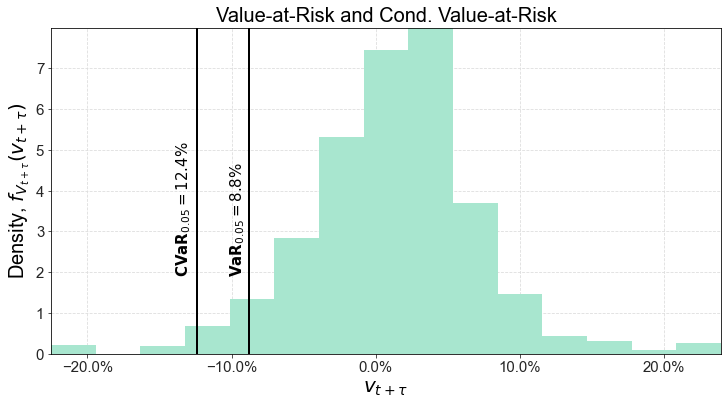

In [12]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=15);

ax.axvline(value_at_risk, ymin=0, ymax=8, color="black")
ax.axvline(cond_value_at_risk, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(-0.102, 2.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(-0.14, 2.0, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 3__

In [13]:
"""
Simulate 12 month log-returns and transform to port. returns
"""
port_w = np.repeat(1.0/5.0, 5)
num_sim = 10000
num_per = 12

sim_log_returns = resample(eq_log_returns.values, num_sim=num_sim, num_per=num_per)
sim_lin_returns = np.exp(sim_log_returns.sum(axis=1)) - 1.0
sim_port_returns = sim_lin_returns @ port_w

"""
Calculate VaR and CVaR
"""

value_at_risk = np.percentile(sim_port_returns, 5)
cond_value_at_risk = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

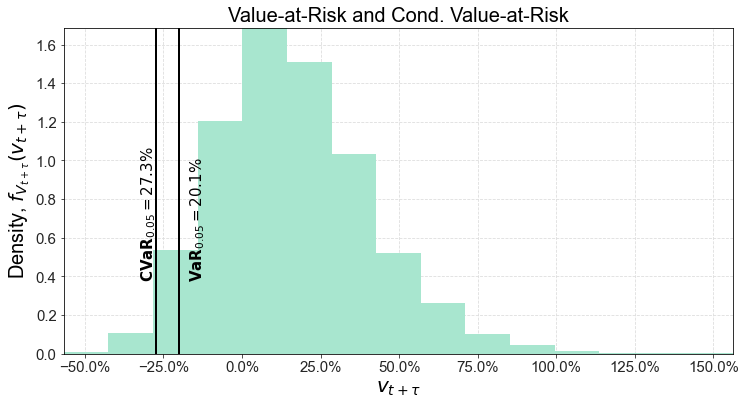

In [14]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=15);

ax.axvline(value_at_risk, ymin=0, ymax=8, color="black")
ax.axvline(cond_value_at_risk, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(value_at_risk + 0.03, 0.4, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(cond_value_at_risk - 0.055, 0.4, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 4__

In [15]:
est_mean = np.mean(sim_port_returns)
est_sigma = np.std(sim_port_returns)
est_skew = stats.skew(sim_port_returns)
est_kurt = stats.kurtosis(sim_port_returns)

cf_var = calculate_cornish_fisher_percentile(0.05, est_mean, est_sigma, est_skew, est_kurt)
cf_var

-0.19320296307468582

## Problem 2: Maximum drawdown

[Drawdown](https://en.wikipedia.org/wiki/Drawdown_(economics)) is a measure of the decline from a historical peak. The drawdown at time $T$ from the starting time $0$ can be defined as (we are using linear returns, but it could also be the loss itself)

$$
DD(T) = \min \left[ \frac{P_T - \max_{t \in (0, T)} P_t}{\max_{t \in (0, T)} P_t}, 0\right]
$$

The maximum drawdown (the most negative return) is 

$$
MDD(T) = \min_{t \in (0, T)} \left[ \frac{P_T - \max_{t \in (0, T)} P_t}{\max_{t \in (0, T)} P_t}, 0\right]
$$

__Question 1__

Implement two functions that calculate respectively the drawdown and maximum drawdown. Let the drawdown function return the drawdown at each point in time. 

__Question 2__

Plot the drawdown of SP500 since 1990-01-01 (hint: use `pandas-datareader`, ticker: '^GSPC', data_source: 'yahoo'). What is the maximum draw down?

### Solution 

__Question 1__

In [16]:
def drawdown(index: np.ndarray):
    
    """
    Calculates the running draw down 
    
    Parameters
    ----------
    index: 
        Values of e.g. at equity index
        
    Returns
    -------
    Tuple(np.ndarray, np.ndarray)
        Drawdown, index of running maximum
    
    """
    
    indexmax = index.cummax()
    drawdowns = (index - indexmax) / indexmax
    
    return drawdowns, indexmax
    
def maxdrawdown(index: np.ndarray):

    """
    Calculates maximum draw down 
    
    Parameters
    ----------
    index: 
        Values of e.g. at equity index
        
    Returns
    -------
    float
        Maximum drawdown
    
    """
    
    return drawdown(index)[0].min()
        

__Question 2__

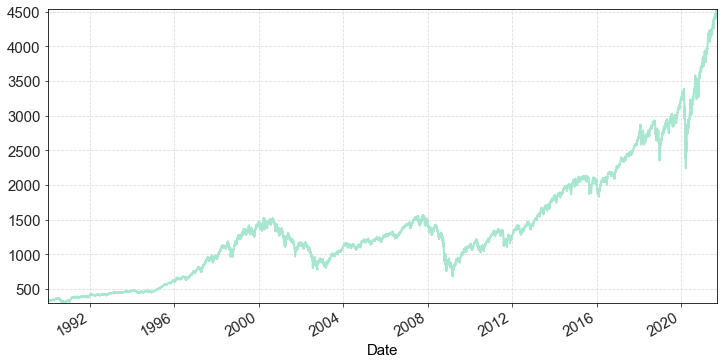

In [17]:
sp500_adjclose = DataReader('^GSPC', 'yahoo', start=datetime.date(1990, 1, 1))['Adj Close']
sp500_adjclose.plot(figsize=(12,6));

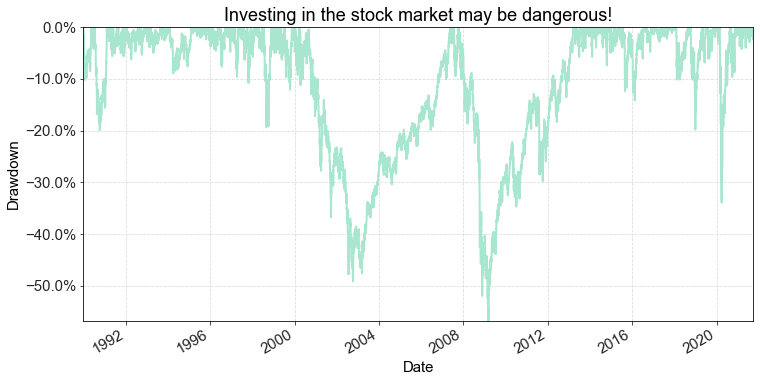

In [18]:
"""
Plotting drawdown plot
"""

ax = drawdown(sp500_adjclose)[0].plot(figsize=(12, 6));

ax.set_title('Investing in the stock market may be dangerous!')
ax.set_ylabel('Drawdown')

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.yaxis.set_major_formatter(xticks)

In [19]:
maxdrawdown(sp500_adjclose)

-0.5677538774277282

## Problem 3: The Student's t distribution 

We assume that the random variable $T$ follows a [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution): 

$$
T = \frac{Z}{\sqrt{\frac{\nu}{V}}} \sim t(\nu)
$$

where $Z\sim N(0,1)$ and $ V \sim \chi^2(\nu)$ are independent, and $\nu$ is the degrees of freedom. The distribution can be represented by the density (pdf)

$$
f_T(t) = \textstyle\frac{\Gamma \left(\frac{\nu+1}{2} \right)} {\sqrt{\nu\pi}\,\Gamma \left(\frac{\nu}{2} \right)} \left(1+\frac{t^2}{\nu} \right)^{-\frac{\nu+1}{2}}\!
$$

__Question 1__

Plot the pdfs for the case $\nu = 2, 10, 50$. Plot the pdf of a standard normal for comparison.

__Question 2__

The t-distribution is used for small sample hypothesis testing when it is reasonable to assume that the radnom sample $X_1, ..., X_n$ is iid from the distribution $N(\mu, \sigma^2)$. 

Define the sample mean 

$$
\bar{X} = \frac{1}{n}\sum_{i=1}^n X_i
$$

and the sample variance

$$
S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2
$$

The "Z-score" (under the normallity assumption)

$$
\frac{\bar{X} - \mu}{\sqrt{\frac{S^2}{n}}} \sim t(n-1)
$$

such that we can construct confidence intervals for $\mu$, the only unknown parameter. 

Simulate 10,0000 samples of size $n=25$ when $X_i \sim N(5, 4)$. For each sample, calculate the sample mean, variance and the "Z-score". Plot a histogram of the Z-scores and compare with the pdf of the true distribution. 

__Question 3__

We want to calculat the expected value of 

$$
g(T) = e^{5 + 10\cdot T}
$$

where $T \sim t(5)$. Calculate this expectation using `scipy.t.expect`. 

__Question 3__

We want to calculat the expected value of 

$$
h(T) = 5 \cdot x^2
$$

where $T \sim t(5)$. Calculate this expectation using `scipy.t.expect`. 


### Solution

__Question 1__

When $\nu \to \infty$ then the t-distribution converges to a standard normal distribution. For small $\nu$ the distribution is more leptokurtic (fatter tails). 

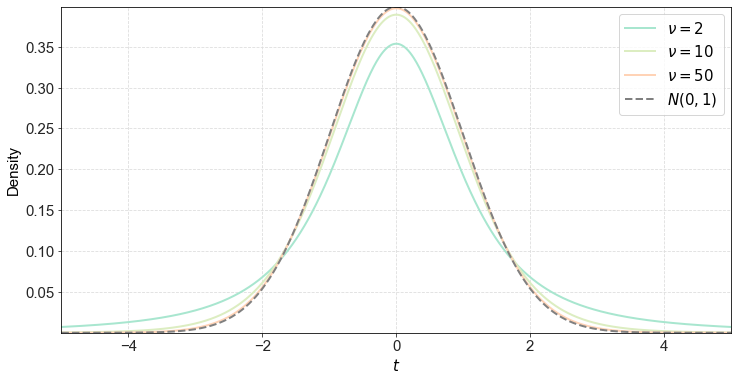

In [24]:
t_values = np.linspace(-5, 5, 1000)
pdf_nu2_values = stats.t.pdf(t_values, 2)
pdf_nu10_values = stats.t.pdf(t_values, 10)
pdf_nu50_values = stats.t.pdf(t_values, 50)
pdf_norm_values = stats.norm.pdf(t_values)


fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(t_values, pdf_nu2_values, label="$\\nu =2$")
ax.plot(t_values, pdf_nu10_values, label="$\\nu =10$")
ax.plot(t_values, pdf_nu50_values, label="$\\nu =50$")
ax.plot(t_values, pdf_norm_values, label="$N(0,1)$", linestyle="--", color="gray")

ax.set_ylabel('Density')
ax.set_xlabel('$t$')
ax.legend();

__Question 2__

It seems that simulate distribution matches the true!

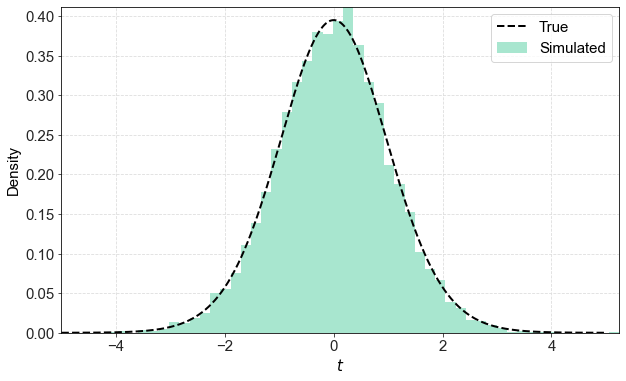

In [38]:
num_sim = 10000
sample_size = 25
mu = 5
sigma = 2

random_draws = np.random.normal(mu, sigma, size=(num_sim, sample_size))
sample_means = np.mean(random_draws, axis=1)
sample_var = np.var(random_draws, axis=1, ddof=1)
sample_z_scores = (sample_means - mu)/np.sqrt(sample_var/(sample_size - 1))

t_values = np.linspace(-5, 5, 1000)
pdf_values = stats.t.pdf(t_values, 25 - 1)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(sample_z_scores, bins=50, density=True, label="Simulated")
ax.plot(t_values, pdf_values, color="black", linestyle="--", label="True")

ax.set_ylabel('Density')
ax.set_xlabel('$t$')
ax.legend();

__Question 3__

In [64]:
"""
Define the function g(t)
"""

def g(t): 
    
    return np.exp(5.0 + 10.0 * t)



"""
Use stats.t.expect
"""

stats.t.expect(g, args=(5,))

inf

__Question 4__

In [63]:
"""
Define the function h(t)
"""

def h(t): 
    
    return 5 * t**2

"""
Use stats.t.expect
"""

stats.t.expect(h, args=(5,))

8.333333333333332

# References

## Articles

## Books